## Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms

Ref) *Adv.Quantum.Technol.* **2** 1900070 (2019): https://arxiv.org/abs/1905.10876  
S.Sim,P.D.Johnson and A.Aspuru-Guzik 

Consider a parameterized quantum circuit $U(\mathbf{x})$, and define the quantity
$$f(\mathbf{x},\mathbf{y}) = |\langle 0 | U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}$$
This quantity is the fidelity of the two states
$$\begin{align*}
|\psi_{\mathbf{x}}\rangle = U(\mathbf{x})|0\rangle~~&\text{and}~~|\psi_{\mathbf{y}}\rangle = U(\mathbf{y})|0\rangle:\\
|\langle \psi_{\mathbf{y}}|\psi_{\mathbf{x}}\rangle|^{2} &= |\langle 0 |U^{\dagger}(\mathbf{y})U(\mathbf{x})|0\rangle|^{2}.
\end{align*}$$

- Suppose we generate a bunch of random realizations of $\mathbf{x},\mathbf{y}$. This gives us a set of random realizations of $f$
$$F = \{f_{1}, f_{2}, \cdots \}.$$

- if the circuit generating that fidelity is drawn from a Haar-random distribution. If the circuit acts on $n$ qubits, the probability of a given fidelity value $f$ is:
$$ \mathrm{Pr}_{\text{Haar}}(f) = (N -1)*(1-f)^{N-2}~~N=2^{n}.$$

- To calculate the probability over a bin of the histogram, we do an integral:
$$\mathrm{Pr}_{\text{Haar}}(j) = \int_{l_{j}}^{u_{j}}  \mathrm{Pr}_{\text{Haar}}(f) ~df =  (1-l_{j})^{N-1}  - (1-u_{j})^{N-1}$$

- The expressibility is then estimated as the KL divergence between the empirically-observed probability distribution (i.e., the histogram) and the probability distribution that would result under a Haar-random unitary.
$$\text{Expr} = \mathrm{KL}(\mathrm{Pr}_{\text{emp}}|| \mathrm{Pr}_{\text{Haar}}) = \sum_{j} \mathrm{Pr}_{\text{emp}}(j)\log\left(\frac{\mathrm{Pr}_{\text{emp}}(j)}{\mathrm{Pr}_{\text{Haar}}(j)}\right)$$

In [1]:
from matplotlib import pyplot
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.extensions import *

from qiskit.quantum_info import random_unitary

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi, sqrt

from scipy.special import rel_entr
from random import seed
from random import random
import cmath

## $Pr_{haar}$

In [2]:
#Possible Bin
bins_list=[];
for i in range(76):
    bins_list.append((i)/75)

#Center of the Bean
bins_x=[]    
for i in range(75):
    bins_x.append(bins_list[1]+bins_list[i])
    
def P_harr(l,u,N):
    return (1-l)**(N-1)-(1-u)**(N-1)

## Fidelities

In [3]:
def get_fidelity(qubit_num, depth, circuit):
    backend = Aer.get_backend('qasm_simulator')
    qubit_num = qubit_num
    nshot = 3000
    nparam = 3000
    fidelity = []

    for x in range(nparam):
    
        theta = [];
        for y in range(80):
            theta.append(2*pi*random())
        
        qc = circuit(qubit_num, depth,theta)    
    
        job = backend.run(qc,shots=nshot)
        result = job.result()
        count = result.get_counts()

        if '0000' in count and '1' in count:
            ratio = count['0000']/nshot
        elif '0000' in count and '1' not in count:
            ratio = count['0000']/nshot
        else:
            ratio = 0
    
        fidelity.append(ratio)
        
    return fidelity


## 4qubit circuit

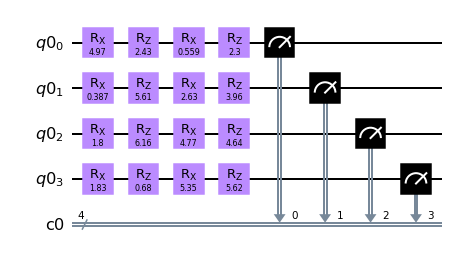

In [4]:
def circuit1(qubit_num, depth, theta):
    qr = QuantumRegister(qubit_num)
    cr = ClassicalRegister(qubit_num)
    qc = QuantumCircuit(qr, cr)
    
    if depth == 0:
        for i in range(qubit_num):
            qc.i(i)
    else:
        for j in range(depth):
            for i in range(qubit_num):
                qc.rx(theta[i+qubit_num*2*j],i)
            for i in range(qubit_num):
                qc.rz(theta[i+qubit_num+qubit_num*2*j],i)
        
    qc.measure(qr[:],cr[:])
    return qc

theta=[];
for _ in range(80):
    theta.append(2*pi*random())
circuit1(4,2,theta).draw('mpl')

In [5]:
qubit_num = 4
depth = 1
fidelity = get_fidelity(qubit_num,depth,circuit1)

In [6]:
#Harr historgram
P_harr_hist = []
for i in range(75):
    P_harr_hist.append(P_harr(bins_list[i],bins_list[i+1],2**qubit_num))

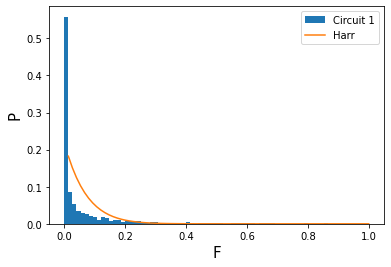

In [7]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, range=[0, 1], label='Circuit 1')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.xlabel('F',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc='upper right')
plt.show()

## KL divergence (relative entropy) with scipy

In [8]:
P_1_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_1_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.720 nats


## 4qubit circuit 2

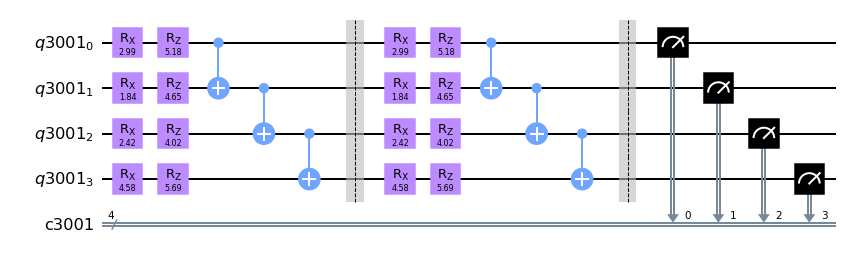

In [9]:
def circuit2(qubit_num, depth, theta):
    qr = QuantumRegister(qubit_num)
    cr = ClassicalRegister(qubit_num)
    qc = QuantumCircuit(qr, cr)

    if depth == 0:
        for i in range(qubit_num):
            qc.i(i)
    else:
        for j in range(depth):    
            for i in range(qubit_num):
                qc.rx(theta[i],i)
            for i in range(qubit_num):
                qc.rz(theta[i+qubit_num],i)
      
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)

            qc.barrier()

    #for i in range(qubit_num):
    #    qc.rx(theta[i],i)
    #for i in range(qubit_num):
    #    qc.rz(theta[i+qubit_num],i)
    qc.measure(qr[:],cr[:])
    return qc

theta=[];
for _ in range(80):
    theta.append(2*pi*random())
circuit2(4,2,theta).draw('mpl')

In [10]:
qubit_num = 4
depth = 3
fidelity = get_fidelity(qubit_num,depth,circuit2)

In [11]:
#Harr historgram
P_harr_hist = []
for i in range(75):
    P_harr_hist.append(P_harr(bins_list[i],bins_list[i+1],2**qubit_num))

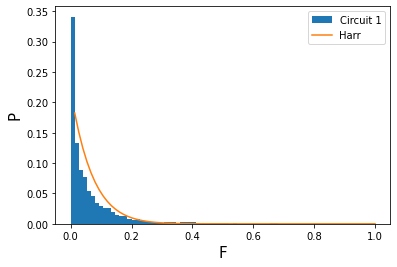

In [12]:
weights = np.ones_like(fidelity)/float(len(fidelity))
plt.hist(fidelity, bins=bins_list, weights=weights, range=[0, 1], label='Circuit 1')
plt.plot(bins_x, P_harr_hist, label='Harr')
plt.xlabel('F',fontsize=15)
plt.ylabel('P',fontsize=15)
plt.legend(loc='upper right')
plt.show()

In [13]:
P_1_hist=np.histogram(fidelity, bins=bins_list, weights=weights, range=[0, 1])[0]
kl_pq = rel_entr(P_1_hist, P_harr_hist)
print('KL(P || Q): %.3f nats' % sum(kl_pq))

KL(P || Q): 0.219 nats


In [14]:
import qiskit.tools.jupyter
%qiskit_version_table